# Adding altitude to each product by interpolation (regridding)

## Load required libraries

In [1]:
import numpy as np 
import pandas as pd 
import netCDF4 as nc 
from netCDF4 import Dataset 
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import matplotlib
import os
import cartopy.crs as ccrs
import cartopy     
from cartopy.feature import NaturalEarthFeature
import cartopy.crs as ccrs 
import cartopy.feature as cf
from cartopy.util import add_cyclic_point
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

## For parallelisation 

In [2]:
from dask.distributed import Client
client = Client(n_workers=16, threads_per_worker=2, memory_limit='32GB')
client

/home/hchaabani/anaconda3/envs/first_part/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34345 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:34345/status,
Dashboard: http://127.0.0.1:34345/status,Workers: 16
Total threads: 32,Total memory: 476.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43273,Workers: 16
Dashboard: http://127.0.0.1:34345/status,Total threads: 32
Started: Just now,Total memory: 476.84 GiB
Comm: tcp://127.0.0.1:39141,Total threads: 2
Dashboard: http://127.0.0.1:34143/status,Memory: 29.80 GiB
Nanny: tcp://127.0.0.1:34417,


## Set variables

In [1]:
# Set the value of threshold that has been used to deduce number of days with snow from scf, it was used also as a 
# constraint while computing monthly values of scf.  
threshold = '0' # <=> threshold% 

period = slice('1982-01-01', '2014-12-31')
latlim = slice(30,34.5)
lonlim = slice(-10, -2)

# Setting input data directory path
path_input = '/home/hchaabani/Data/Snow/snc/cmip6/modified_data/monthly/monthly_values/monthly_values_threshold_'+threshold
path_topo = '/home/hchaabani/Data/topo_atlas'  

# Setting output data directory path   
path_output = '/home/hchaabani/Data/Snow/snc/cmip6/modified_data/monthly/monthly_values_plus_alt/monthly_values_threshold_'+threshold

dic_data = {'BCC-CSM2-HR':'data'}

products_labels = ['BCC-CSM2-HR']

##  Importing and preparing data 

In [4]:
topo_6km = xr.open_dataset(path_topo + '/topo_atlas_GMT_00625.nc').sel(latitude=latlim, longitude=lonlim).load()

#latlim = slice(34.5,30) 
dic_data['BCC-CSM2-HR'] = xr.open_dataset(path_input + '/BCC-CSM2-HR_variables_monthly_values_threshold_'+threshold+'.nc').sel(time=period).sel(lat=latlim, lon=lonlim).load()


## Check elevation data

In [5]:
# This auxiliary function will help us in the formatting of the figures
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

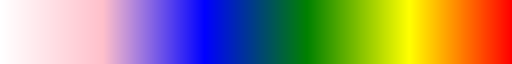

In [6]:
import matplotlib as mpl
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

c0='white'
c1='pink' 
c2='blue' 
c3='green' 
c4='yellow' 
c5='red' 

n=250

colors0 = []
colors1 = []
colors2 = []
colors3 = []
colors4 = []
for x in range(n+1):
    colors0.append(colorFader(c0,c1,x/n))
    colors1.append(colorFader(c1,c2,x/n))
    colors2.append(colorFader(c2,c3,x/n))
    colors3.append(colorFader(c3,c4,x/n))
    colors4.append(colorFader(c4,c5,x/n))

colors = colors0 + colors1 + colors2 + colors3 + colors4

cmap_init = mpl.colors.ListedColormap(colors)
cmap_init

/tmp/ipykernel_34614/2028005346.py:49: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(cs, cax=cbar_ax, cmap=cmap_init, label='altitude in m', ticks=[val for val in range(0,3400,200)], orientation='horizontal') #  ) # extend='right


/home/hchaabani/anaconda3/envs/first_part/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/hchaabani/anaconda3/envs/first_part/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/hchaabani/anaconda3/envs/first_part/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/hchaabani/anaconda3/envs/first_part/li

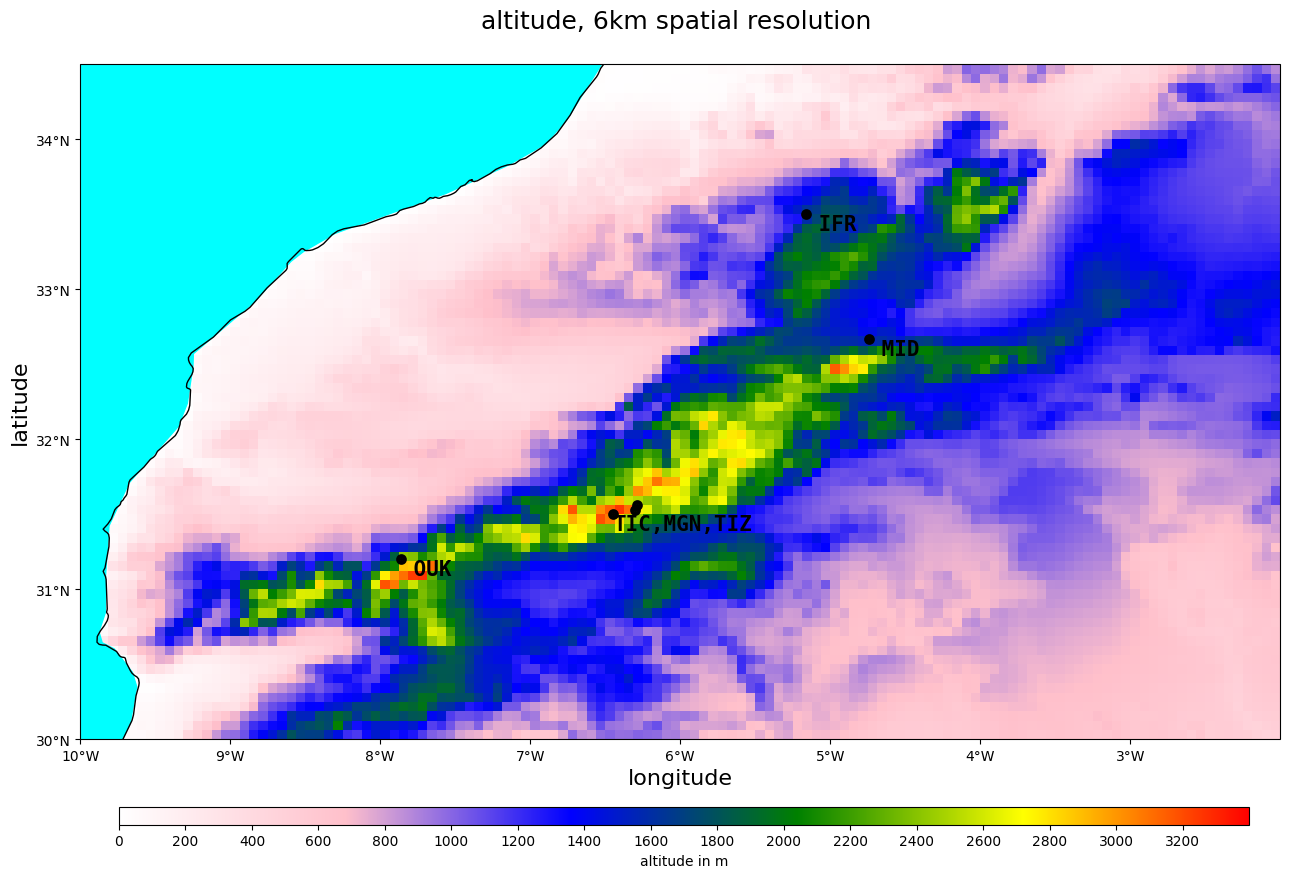

In [7]:
# We define stations labels and coordinates to be ploted on the map
statios_colors = ["darkgreen","orange", "lemonchiffon","khaki", "palegoldenrod","darkblue"]
lats = np.array([33.5,32.67,31.53,31.50,31.56,31.20])
lons = np.array([-5.16,-4.74,-6.30,-6.45,-6.29,-7.86])
names = [" IFR", " MID", "", "TIC,MGN,TIZ", "", " OUK"]  
  
fig, ax = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()}) #   figsize=(11,8.5)
        
# Formatting figure 
plt.subplots_adjust(wspace=0.06,hspace=0.04)
set_size(12,7)      

# Plot altitude
cs=topo_6km['elevation'].plot(ax=ax, cmap=cmap_init , add_colorbar=False, vmin=0, vmax=3400, add_labels=False)
        
ax.add_feature(cf.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='cyan'))
ax.set_extent([ -10, -2, 30, 34.5])
                
# Pointing the stations on one of the boxplots
# if ['ESA_GF','ESA_ORIG'].count(key):
ax.scatter(lons, lats, 30, color='black', marker=".", edgecolor='black', linewidth=5)
for j in range(len(names)):
    ax.text(lons[j], lats[j], names[j], va="top", family="monospace", weight="bold", fontsize=15, color='black')

# Draw the coastines for each subplot
ax.coastlines()
    
ax.set_title('altitude, 6km spatial resolution \n',  fontsize=18)
      
# Longitude labels
for i in [2,3]:
    ax.set_xticks(np.arange(-10,-2,1), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.set_xlabel('longitude', fontsize=16) 

# Latitude labels
for i in [0,2]:
    ax.set_yticks(np.arange(30,34.5,1), crs=ccrs.PlateCarree())
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('latitude', fontsize=16) 
    
# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.15, 0.03, 0.73, 0.02])

# Draw the colorbar   
fig.colorbar(cs, cax=cbar_ax, cmap=cmap_init, label='altitude in m', ticks=[val for val in range(0,3400,200)], orientation='horizontal') #  ) # extend='right
        
# Store figures 
#plt.savefig(output_path_figures+'/'+par+'_'+key_mon+'_months_average_with_ERA5.pdf')
#plt.savefig(output_path_figures+'/'+par+'_'+key_mon+'_months_average_with_ERA5.png')

## Regridding

In [8]:
topos_regridded = {key:'elevation' for key in products_labels}
products_plus_elev = {key:'data' for key in products_labels}

In [9]:
dic_data

{'BCC-CSM2-HR': <xarray.Dataset>
 Dimensions:                (lon: 18, lat: 10, time: 396)
 Coordinates:
   * lon                    (lon) float64 -9.9 -9.45 -9.0 ... -3.15 -2.7 -2.25
   * lat                    (lat) float64 30.34 30.79 31.24 ... 33.48 33.93 34.38
   * time                   (time) datetime64[ns] 1982-01-01 ... 2014-12-01
 Data variables:
     snc_monthly_value      (time, lat, lon) float32 nan nan nan ... nan nan nan
     days_with_snow         (time, lat, lon) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
     days_without_snow      (time, lat, lon) int64 31 31 31 31 31 ... 31 31 31 31
     days_with_data         (time, lat, lon) int64 31 31 31 31 31 ... 31 31 31 31
     days_of_month          (time, lat, lon) int64 31 31 31 31 31 ... 31 31 31 31
     snc_monthly_value_15   (time, lat, lon) float32 nan nan nan ... nan nan nan
     days_with_snow_15      (time, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
     days_without_snow_15   (time, lat, lon) float64 31.0 31.0 31.0 ...

In [10]:
for prod in products_labels:
    regridder = xe.Regridder(topo_6km, dic_data[prod], "conservative")
    topos_regridded[prod] = regridder(topo_6km, keep_attrs=True)
    products_plus_elev[prod] = dic_data[prod]
    products_plus_elev[prod]['elevation'] = topos_regridded[prod]['elevation']


## Check examples

/tmp/ipykernel_34614/1796779051.py:58: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(cs, cax=cbar_ax, cmap=cmap_init, label='snow cover in %', ticks=[val for val in range(0,40,5)], orientation='horizontal') #  ) # extend='right


/home/hchaabani/anaconda3/envs/first_part/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/hchaabani/anaconda3/envs/first_part/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/hchaabani/anaconda3/envs/first_part/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/hchaabani/anaconda3/envs/first_part/li

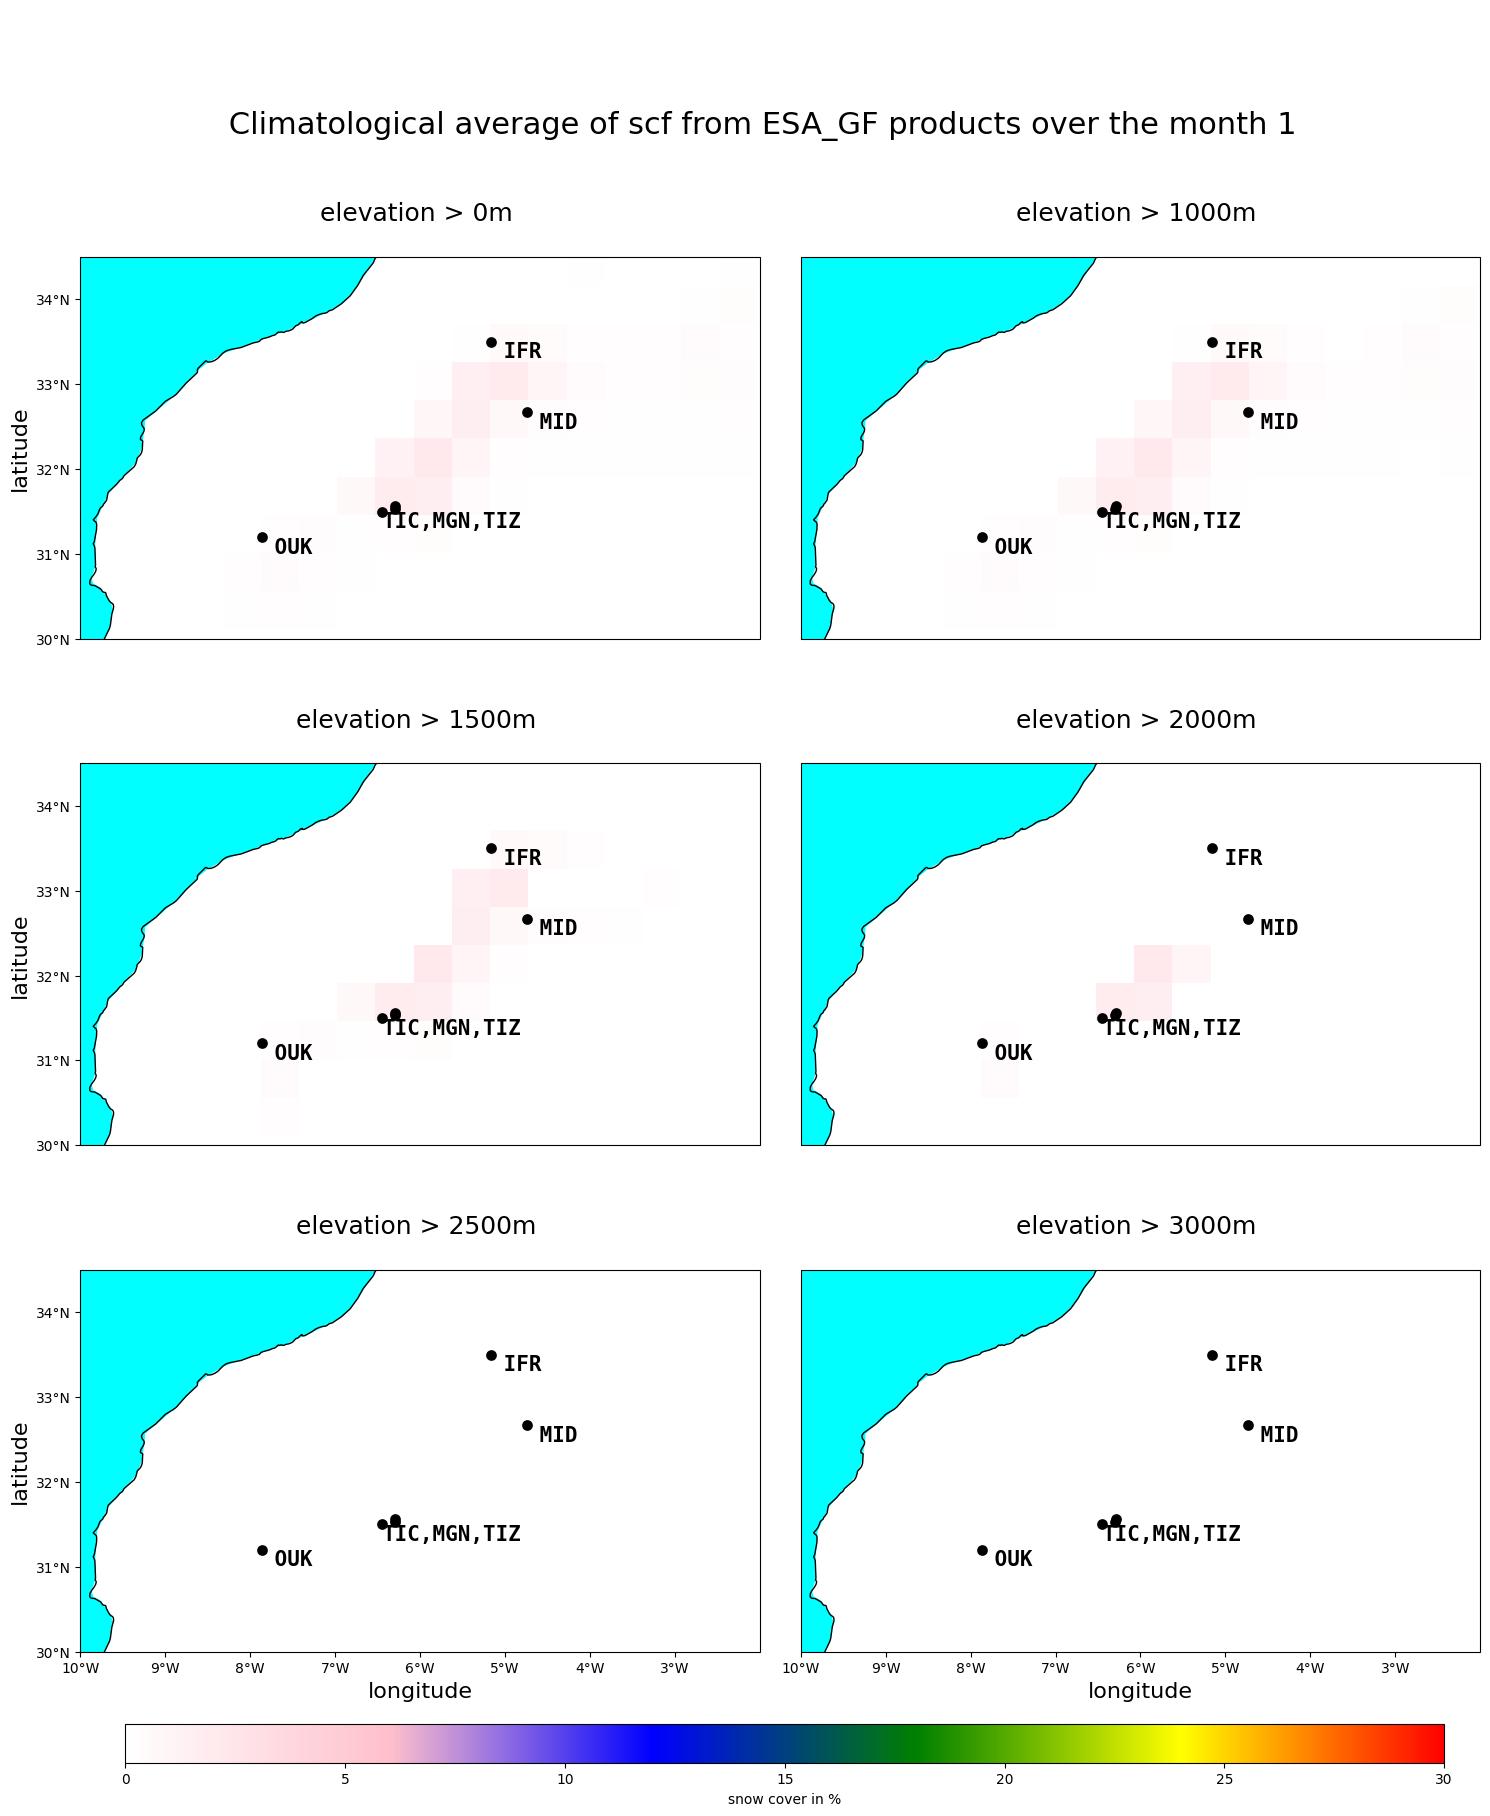

In [11]:
# We define stations labels and coordinates to be ploted on the map
statios_colors = ["darkgreen","orange", "lemonchiffon","khaki", "palegoldenrod","darkblue"]
lats = np.array([33.5,32.67,31.53,31.50,31.56,31.20])
lons = np.array([-5.16,-4.74,-6.30,-6.45,-6.29,-7.86])
names = [" IFR", " MID", "", "TIC,MGN,TIZ", "", " OUK"]  
  
fig, axs = plt.subplots(nrows=3,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()}) #   figsize=(11,8.5)
        
# Formatting figure 
plt.subplots_adjust(wspace=0.06,hspace=0.04)
set_size(14,15)      

# Axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array as follow 
axs=axs.flatten()

i=0 
for lim in [0, 1000,1500, 2000, 2500, 3000]:

    # Plot altitude
    cs=products_plus_elev['BCC-CSM2-HR'].where(products_plus_elev['BCC-CSM2-HR']['elevation']>lim)['ext_days_with_snow_15'].groupby('time.month')[1].mean(dim='time').plot(ax=axs[i], cmap=cmap_init , add_colorbar=False, vmin=0, vmax=30, add_labels=False)
        
    axs[i].add_feature(cf.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='cyan'))
    axs[i].set_extent([ -10, -2, 30, 34.5])
                
    # Pointing the stations on one of the boxplots
    #if ['ESA_GF','ESA_ORIG'].count(key):
    axs[i].scatter(lons, lats, 30, color='black', marker=".", edgecolor='black', linewidth=5)
    for j in range(len(names)):
        axs[i].text(lons[j], lats[j], names[j], va="top", family="monospace", weight="bold", fontsize=15, color='black')

    # Draw the coastines for each subplot
    axs[i].coastlines()
    
    axs[i].set_title('elevation > '+str(lim)+'m \n',  fontsize=18)
    
    i = i+1
    
# Longitude labels
for i in [4,5]:
    axs[i].set_xticks(np.arange(-10,-2,1), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)
    axs[i].set_xlabel('longitude', fontsize=16) 

# Latitude labels
for i in [0,2,4]:
    axs[i].set_yticks(np.arange(30,34.5,1), crs=ccrs.PlateCarree())
    lat_formatter = LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    axs[i].set_ylabel('latitude', fontsize=16) 
    
# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.15, 0.08, 0.73, 0.02])

fig.suptitle('\n \n \n Climatological average of scf from ESA_GF products over the month 1', fontsize=22)
# Draw the colorbar   
fig.colorbar(cs, cax=cbar_ax, cmap=cmap_init, label='snow cover in %', ticks=[val for val in range(0,40,5)], orientation='horizontal') #  ) # extend='right
        
# Store figures 
#plt.savefig(output_path_figures+'/name.pdf')
#plt.savefig(output_path_figures+'/name.png')

##  Store the new data with elevation

In [12]:
for prod in products_labels:
    products_plus_elev[prod].to_netcdf(path_output + '/'+prod+'_variables_monthly_values_threshold_'+threshold+'.nc')